# Measuring diversity

As important diversity is for cities, as complicated is to capture it. `momepy` offers several options on how to do that using urban morphometrics. Generally, we can distinguish three types of diversity characters, based on:

1. Absolute values
2. Relative values
3. Categorization (binning)

This notebook provides examples from each of them.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.projection.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Loop 1 out of 2.
Changing geometry: 100%|██████████| 630/630 [00:04<00:00, 139.19it/s]
Loop 2 out of 2.
Changing geometry: 100%|██████████| 172/172 [00:01<00:00, 171.60it/s]
Inward offset...
Discretization...
100%|██████████| 2008/2008 [00:03<00:00, 539.65it/s]
Generating Voronoi diagram...
Vertices to Polygons: 100%|██████████| 249298/249298 [00:05<00:00, 48488.06it/s]
Dissolving Voronoi polygons...
Preparing limit for edge resolving...
Building R-tree...
100%|██████████| 235/235 [00:00<00:00, 787.03it/s]


### Queen contiguity

Morphological tessellation allows using contiguity-based weights matrix. While `libpysal.weights.contiguity.Queen` will do a classic Queen contiguity matrix; it might not be enough to capture proper context. For that reason, we can use `momepy.sw_high` to capture all neighbours within set topological distance `k`. More in [Generating spatial weights](weights_nb.ipynb).

In [3]:
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

To have a character whose diversity can be measured, we can use the area of tessellation.

In [4]:
tessellation['area'] = momepy.Area(tessellation).series

### Range

The range is as simple as it sounds; it measures the range of the values withing all neighbours as captured by `spatial_weights`.

In [5]:
area_rng = momepy.Range(tessellation, values='area',
                                        spatial_weights=sw3, unique_id='uID')
tessellation['area_rng'] = area_rng.series

100%|██████████| 2005/2005 [00:01<00:00, 1884.07it/s]


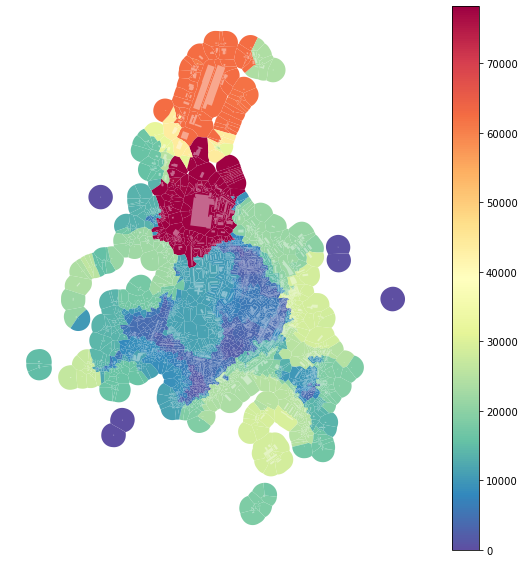

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_rng', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

However, as we can see from the plot above, there is a massive effect of large-scale buildings, which can be seen as outliers. For that reason, we can define `rng` keyword argument to limit the range taken into account. To get the interquartile range:

In [7]:
area_iqr = momepy.Range(tessellation, values='area',
                        spatial_weights=sw3, unique_id='uID',
                        rng=(25, 75))
tessellation['area_IQR'] = area_iqr.series

100%|██████████| 2005/2005 [00:01<00:00, 1692.15it/s]


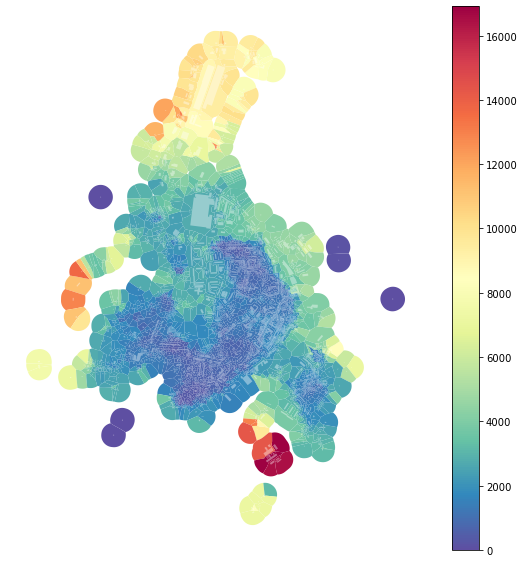

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_IQR', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

The effect of outliers has been successfully eliminated.

### Theil index

Theil index is a measure of inequality (as Gini index is). `momepy` is using `pysal`'s implementation of the Theil index to do the calculation.

In [9]:
area_theil = momepy.Theil(tessellation, values='area',
                          spatial_weights=sw3,
                          unique_id='uID')
tessellation['area_Theil'] = area_theil.series

100%|██████████| 2005/2005 [00:02<00:00, 768.95it/s]


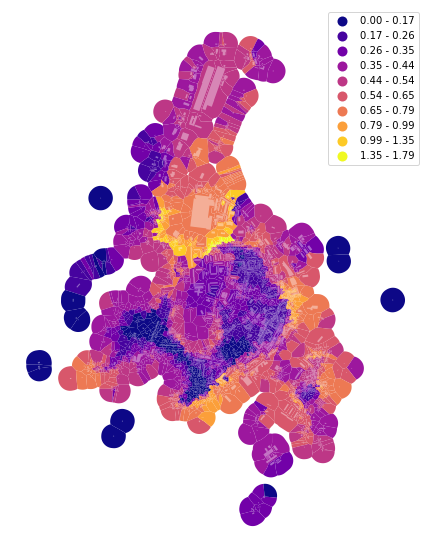

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_Theil', scheme='fisherjenks', k=10, legend=True, cmap='plasma')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

Again, the outlier effect is present. We can use the same keyword as above to limit it and measure the Theil index on the inter-decile range.

In [11]:
area_id_theil = momepy.Theil(tessellation, values='area',
                             spatial_weights=sw3,
                             unique_id='uID',
                             rng=(10, 90))
tessellation['area_Theil_ID'] = area_id_theil.series

100%|██████████| 2005/2005 [00:01<00:00, 1537.62it/s]


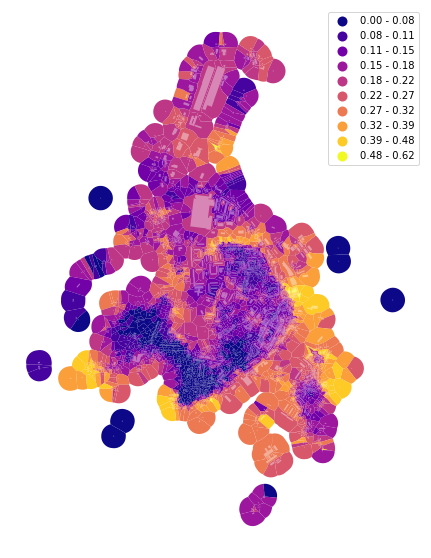

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_Theil_ID', scheme='fisherjenks', k=10, legend=True, cmap='plasma')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

### Simpson's diversity index

Simpson's diversity index is one of the most used indices capturing diversity. However, we need to be careful using it for continuous values, as it depends on the binning of these values to categories. The effect of different binning could be significant. `momepy` uses Head/tail Breaks as a large number of morphometric characters follows power-law distribution (for which Head/tail Breaks are designed). However, you can use any binning provided by `mapclassify` (including user-defined). The default Head/tail Breaks:

In [13]:
area_simpson = momepy.Simpson(tessellation, values='area',
                              spatial_weights=sw3,
                              unique_id='uID')
tessellation['area_simpson'] = area_simpson.series

100%|██████████| 2005/2005 [00:01<00:00, 1002.51it/s]


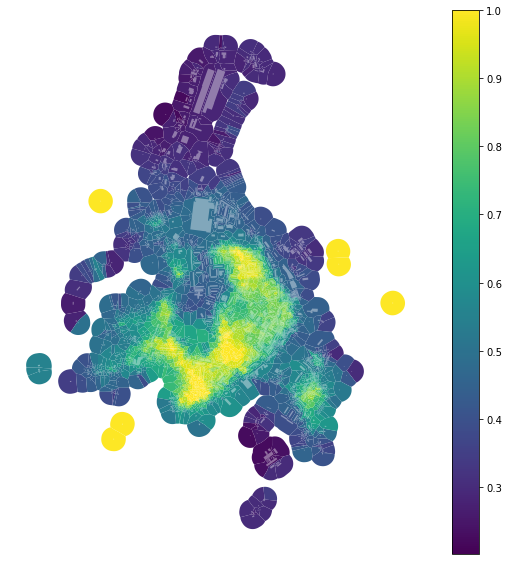

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_simpson', legend=True, cmap='viridis')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

And binning based on quantiles (into 7 bins of equal size):

In [15]:
tessellation['area_simpson_q7'] = momepy.Simpson(tessellation, values='area',
                                                 spatial_weights=sw3,
                                                 unique_id='uID',
                                                 binning='quantiles', k=7).series

100%|██████████| 2005/2005 [00:02<00:00, 951.87it/s]


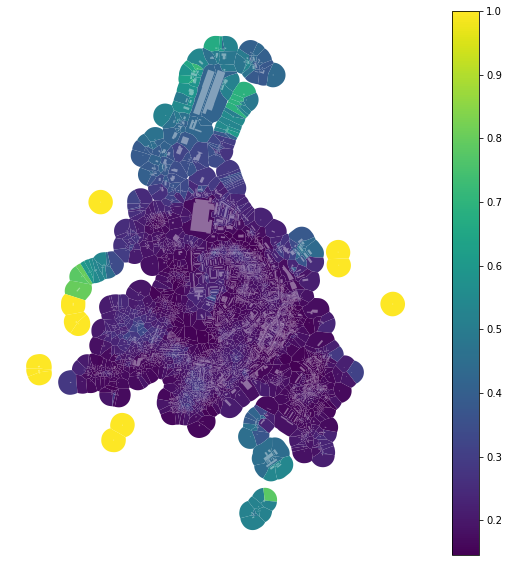

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='area_simpson_q7', legend=True, cmap='viridis')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

Always consider whether your binning is the optimal one.